# **Прогноз покупательской активности**
<br>

**<font size=4>Описание</font>**

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. <br> Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

<br>

**<font size=4>Цель</font>**

Предсказать вероятность покупки в течение 90 дней.

<br>

**<font size=4>Задачи:</font>**

- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

<br>


**<font size=4>Этапы работы:</font>**

- [Загрузка данных](#1)
- [Предобработка данных](#2)
- [Исследовательский анализ данных](#3)
- [Генерация новых признаков](#5)
- [Корреляционный анализ](#4)
- [Модели МО](#6)
- [Итоговый вывод](#8)

### **Импорт библиотек**

In [3]:
import numpy as np
import pandas as pd

from scipy.stats import mode
from functools import reduce

from sklearn.metrics import f1_score

import shap

from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import optuna
from optuna.integration import OptunaSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

# ? используется только в файле с функциями
# from IPython.display import display, HTML
# import io

# временные импорты
# import import_ipynb
# # import importlib
# import sys

import utils as u

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


<a name='1'></a>

## **Загрузка данных**

Информация о пользователях и их покупках предоставлена в **5 таблицах**, которые хранятся в папке **`datasets`**.

<br>

**<font size=4>Описание данных:</font>**

<br>

**<font size=3>`apparel-purchases`</font>** - история покупок

- `client_id` - идентификатор пользователя
- `quantity` - количество единиц товара
- `price` - цена товара
- `category_ids` - идентификаторы категорий
- `date` - дата покупки
- `message_id` - идентификатор сообщения из рассылки

<br>

**<font size=3>`apparel-messages`</font>** - история рекламных рассылок

- `bulk_camaign_id` - идентификатор рассылки
- `client_id` - идентификатор клиента
- `message_id` - идентификатор сообщения
- `event` - действие с сообщением (отправлено, открыто, покупка...)
- `channel` - канал рассылки
- `date` - дата действия
- `created_at` - дата-время полностью

<br>

**<font size=3>`apparel-target_binary`</font>** - совершит ли клиент покупку в течение следующих 90 дней

- `client_id` - идентификатор клиента
- **`target`** - **целевой признак**, клиент совершил покупку в целевом периоде

<br>

**<font size=3>`full_campaign_daily_event`</font>** - агрегация общей базы рассылок по дням и типам событий

- `date` - дата
- `bulk_campaign_id` - идентификатор рассылки
- `count_event*` - общее количество каждого события `event`
- `nunique_event` - количество уникальных `client_id` в каждом событии

<br>

**<font size=3>`full_campaign_daily_event_channel`</font>** - агрегация по дням с учетом событий и каналов рассылки

- `date` - дата
- `bulk_campaign_id` - идентификатор рассылки
- `count_event*_channel*` - общее количество каждого события по каналам
- `nunique_event_channel*` - количество уникальных `client_id` по событиям и каналам

<br>

\* в именах колонок есть все типы событий `event` и каналов рассылки `channel`


In [5]:
purchases, messages, target, campaign_daily_event, campaign_daily_event_channel = u.load_files(
    ['apparel-purchases', 'apparel-messages', 'apparel-target_binary', 
     'full_campaign_daily_event', 'full_campaign_daily_event_channel'],
    [[], ['date', 'created_at'], False, [], []])

**<font size=4>Первичный анализ данных</font>**

<br>

**<font size=3>Таблица `purchases`</font>**

**Размерность:** 202 208 строк, 6 столбцов.

Данная таблица содержит историю покупок каждого пользователя, следовательно столбец **`client_id` не является уникальным** для этой таблицы. 

Также цена `price` указана за единицу товара, поэтому при одном заказе разных товаров должны создаваться отдельные строки в таблице для каждого товара. Будем считать, что один **заказ** - это строки таблицы конкретного покупателя, у которых совпадает дата покупки. 

Также можно предположить, что в данной таблице столбец `message_id` указывает на какой-то конкретный тип события, например, "покупка". Данный столбец включает в себя `client_id`.

<br>

**<font size=3>Таблица `messages`</font>**

**Размерность:** 12 739 798 строк, 7 столбцов.

**Таблица** с историей рекламных рассылок - самая объемная таблица, которая **содержит максимальное количество строк**. 

Идентификатор рассылки `bulk_camaign_id` не является уникальным, так как одинаковая рассылка может быть отправлена разным пользователям, а таблица хранит информацию о действиях с каждой рассылкой (отправлено, открыто и т.д.). Значение идентификатора также содержится в столбце `message_id`.

Существуют определенные события и каналы рассылки. Также существует столбец `created_at`, содержащий и дату, и время с точностью до секунд.

<br>

**<font size=3>Таблица `target`</font>**

**Размерность:** 49 849 строк, 2 столбца.

В данной таблице всего два столбца:

- `client_id` - идентификатор клиента
- **`target`** - **бинарный целевой признак**, который хранит информацию о том, совершит ли клиент покупку в течение следующих 90 дней, где **0 - не совершит** покупку, **1 - совершит** покупку.

<br>

**<font size=3>Таблицы `campaign_daily_event` и `campaign_daily_event_channel`</font>** - агрегация общей базы рассылок по дням и типам событий

**Размерность:** 131 072 строки, 24 столбца и 131 072 строки, 36 столбцов соответственно

В данных таблицах содержится информация о каждом дне для определенной рассылки, какое событие, сколько раз произошло, а также количество уникальных пользователей в каждом событии. Во второй таблице также учитываются каналы рассылки.


### **Выводы**

Были загружены **5 таблиц** различного размера. Самая большая — `messages` (12.7 млн строк), самая маленькая — `target` (49.8 тыс. строк).

- Таблица `purchases` содержит историю покупок, где заказы представлены отдельными строками, `message_id` может связывать покупки с рассылками.
- Таблица `messages` хранит подробности о рассылках: события, каналы, временные метки.
- Таблица `target` содержит бинарный целевой признак, указывающий на вероятность покупки в ближайшие 90 дней.
- Агрегационные таблицы показывают статистику по событиям и каналам для кампаний, что полезно для анализа их эффективности.


<a name='2'></a>

## **Предобработка данных**

### **Обработка пропусков**

Проверим данные на наличие пропусков.

In [10]:
dfs = [purchases, messages, target, campaign_daily_event, campaign_daily_event_channel]
names = ['purchases', 'messages', 'target', 'campaign_daily_event', 'campaign_daily_event_channel']

In [11]:
u.process_dfs(names, dfs, u.is_na)

В таблицах отсутствуют пропуски.

### **Дубликаты**

**<font size=4>Явные дубликаты</font>**

Уникальные идентификаторы строк присутствуют только в таблицах `target`, `campaign_daily_event` и `campaign_daily_event_channel`. Для первой таблицы это столбец `client_id`, а для агрегированных таблиц идентификатор состоит из двух столбцов: `date` и `bulk_campaign_id`.

Проверим, есть ли в данных таблицах явные дубликаты.

In [14]:
columns = ['client_id']
target['client_id'].duplicated().sum()

0

In [15]:
columns = ['date', 'bulk_campaign_id']
campaign_daily_event[columns].duplicated().sum()

0

In [16]:
campaign_daily_event_channel[columns].duplicated().sum()

0

Одинаковые идентификаторы в таблицах отсутствуют.

Теперь посмотрим, присутствуют ли в данных полные дубликаты.

In [18]:
u.process_dfs(names, dfs, u.is_duplicates)


**<font size=3>Таблица `purchases`</font>**

В данной таблице более 36% полных дубликатов. Причина возникновения таких записей может быть связана либо с поведением пользователей, либо с особенносями работы системы. В первом случае может быть несколько вариантов:

- пользователь купил недостаточное количество товара и сделал повторный заказ
- пользователь не был уверен в оформлении заказа, например, из-за некорректного отображения статуса заказа, из-за чего сделал повторную покупку

Также из-за ошибок системы одна покупка с несколькими единицами товара, может записываться, как несколько одинаковых покупок.

Так как доля дубликатов достаточно велика, будем считать, что все покупки были успешно совершены.

<br>

**<font size=3>Таблица `messages`</font>**

В таблице 0.38% дубликатов. Можно заметить, что есть дубликаты с событием clik, которое появляется после взаимодействия пользователя, из-за чего возникновение данных дубликатов похоже на следствие ложного срабатывания системы. Так как дубликатов менее 1%, их можно удалить.

<br>

В остальных таблицах нет полных дубликатов.

<br>

Удалим полные дубликаты из таблицы `messages`

In [21]:
messages = messages.drop_duplicates()
u.is_duplicates(messages)

**<font size=4>Неявные дубликаты</font>**

В таблице `purchases` присутствует столбец `category_ids`, содержащий список категорий, относящихся к товару. Перед анализом категориальных признаков преобразуем значения данного столбца к списку с целочисленными значениями.

In [24]:
purchases['category_ids'] = purchases['category_ids'].apply(u.parse_list)

purchases.sample(5)

,client_id,quantity,price,category_ids,date,message_id
59160,1515915625501998816,1,99.0,"[5562, 5597, 5637, 905]",2022-11-17,1515915625501998816-7879-6374873b91c17
139863,1515915625489300883,1,1539.0,"[5562, 5630, 5547, 552]",2023-06-15,1515915625489300883-13351-6489abe2e8e47
43396,1515915625578530629,1,1586.0,"[4, 28, 62, 657]",2022-11-10,1515915625487918003-7659-6368e575bf4d1
109947,1515915625468151190,1,559.0,"[4, 1822, 1827, 1817]",2023-04-28,1515915625468151190-12218-644b822aaac5b
28745,1515915625488250388,1,2399.0,"[4, 28, 260, 420]",2022-08-04,1515915625488250388-5782-62ea2ea76d2db


Столбец `category_ids` был успешно преобразован. Пустые списки были записаны значением [-1].

Теперь ознакомимся с уникальными значениями категориальных столбцов.

In [26]:
dfs = [purchases, messages, target, campaign_daily_event, campaign_daily_event_channel]

In [27]:
u.process_dfs(names, dfs, u.unique)

**<font size=3>Таблица `purchases`</font>**

В таблице два категориальных признака: `categoty_ids` и `message_id`. Всего 1152 категорий и подкатегорий товаров, самые популярные из них скорее всего встречаются на верхних уровнях вложеноости. Также значения `message_id` иногда дублируются.

<br>

**<font size=3>Таблица `messages`</font>**

Существует всего два канала рассылки: `mobile_push` и  `email`. Первый канал используется чаще, это может говорить о том, что многие покупатели используют мобильное приложение.

Было обнаружено 11 событий:

- **`send` - отправка сообщения**. Сообщение (например, электронное письмо или push-уведомление) было отправлено пользователю.
- **`open` - открытие сообщения**. Пользователь открыл электронное письмо или прочитал уведомление.
- **`click` - клик по ссылке**. Пользователь нажал на ссылку в сообщении (например, на кнопку, изображение или текстовую ссылку).
- **`purchase` - покупка**. Пользователь совершил покупку.
- **`hard_bounce` - жесткий отказ доставки**. Электронное письмо не было доставлено, так как адресат не существует или почтовый сервер его заблокировал.
- **`soft_bounce` - мягкий отказ доставки**. Электронное письмо временно не может быть доставлено (например, из-за переполненного почтового ящика или временных технических проблем на сервере).
- **`unsubscribe` - отписка**. Пользователь отказался от подписки на рассылку.
- **`hbq_spam` - сообщение помечено как спам** (HBQ = High Bounce Quality). Пользователь или почтовый сервер пометил сообщение как спам. Это может повлиять на репутацию отправителя.
- **`complain` - жалоба на сообщение**. Пользователь активно пожаловался на сообщение, например, на платформе почтового сервиса (обычно также сопровождается меткой "спам").
- **`subscribe` - подписка**. Пользователь подписался на рассылку.
- **`close` - закрытие сообщения**. Пользователь закрыл сообщение, не совершив других действий (например, не кликнув на ссылки или кнопки).

Данные категории можно использовать для генерации новых признаков и отбора пользователей, например, наличие события `hard_bounce` говорит о том, что данный пользователь не может участвовать в рассылке, следовательно не стоит учитывать таких пользователей и удалять их из базы.
<br>

В остальных таблицах отсутствуют категориальные признаки.


### **Преобразование признаков**

В таблице `purchases` находится список категорий товаров. Для дальнейшего анализа выделим в отдельные столбцы карегории первого и последнего уровня.

In [30]:
purchases['first_category'] = purchases['category_ids'].apply(lambda x: x[0])
purchases['last_category'] = purchases['category_ids'].apply(lambda x: x[-1])

purchases.sample(5)

,client_id,quantity,price,category_ids,date,message_id,first_category,last_category
55495,1515915625490440118,1,1458.0,"[2, 18, 217, 663]",2022-11-15,1515915625490440118-7845-63733595627b2,2,663
44578,1515915625488998293,1,999.0,"[4, 28, 249, 615]",2022-11-11,1515915625488998293-7803-636dfed593413,4,615
78162,1515915625590744425,1,666.0,"[4, 31, 324, 466]",2022-12-24,1515915625468245507-8958-63a573c64534a,4,466
162135,1515915625987122756,1,333.0,"[4, 28, 57, 431]",2023-08-10,1515915625489338719-13614-64d389a4ea531,4,431
78703,1515915625468093885,1,3500.0,"[4, 28, 249, 616]",2022-12-26,1515915625566602964-8902-63a2ceb9da4fe,4,616


### **Вывод** 

В результате предобработки данных:

- подтверждено отсутствие пропусков в таблицах
- удалены полные дубликаты в таблице `messages`
- получен список уникальных событий
- обнаружено два канала рассылки
- выделены двекатегории товаров

<a name='3'></a>

## **Исследовательский анализ данных**

Изучим сводную статистику таблиц.

In [33]:
dfs = [purchases, messages, target, campaign_daily_event, campaign_daily_event_channel]
names = ['purchases', 'messages', 'target', 'campaign_daily_event', 'campaign_daily_event_channel']

def describe_num(data, is_one=False):
    return data.describe().to_html()

In [34]:
u.process_dfs(names, dfs, describe_num)

Данные о пользователях собирались в период с 16.05.2022 по 16.02.2024, а агрегированные таблицы были составлены на 3 месяца позже.

Более чем в 75% случаев количество единиц товара равняется 1, что подтверждает предположение о том, что это особенности работы системы.

Существуют товары, стоимостью 1, а также товары, сильно превосходящие среднюю стоимость.

В целевом признаке существует дисбаланс классов - более 75% пользователей не совершат покупку в течение 90 дней.

Последние две таблицы содержат информацию о рассылках, а не о пользователях, поэтому они будут не очень информативными в контексте данной задачи. Для дальнейшего анализа эти таблицы не будут рассматриваться.

<br>

Ознакомимся подробнее с таблицами `purchases`, `messages` и `target`, построим графики и изучим распределения.

**<font size=3>Таблица `purchases`</font>**

В таблице 2 количественных признака:

- `quantity` - дискретный (данный признак стоит рассматривать, как категориальный), количество единиц товара
- `price` - непрерывный, цена товара

2 категориальных признака:

- `first_category` - идентификатор первой категори
- `last_category` - идентификатор последней категори

1 временной признак:

- `date` - дата покупки



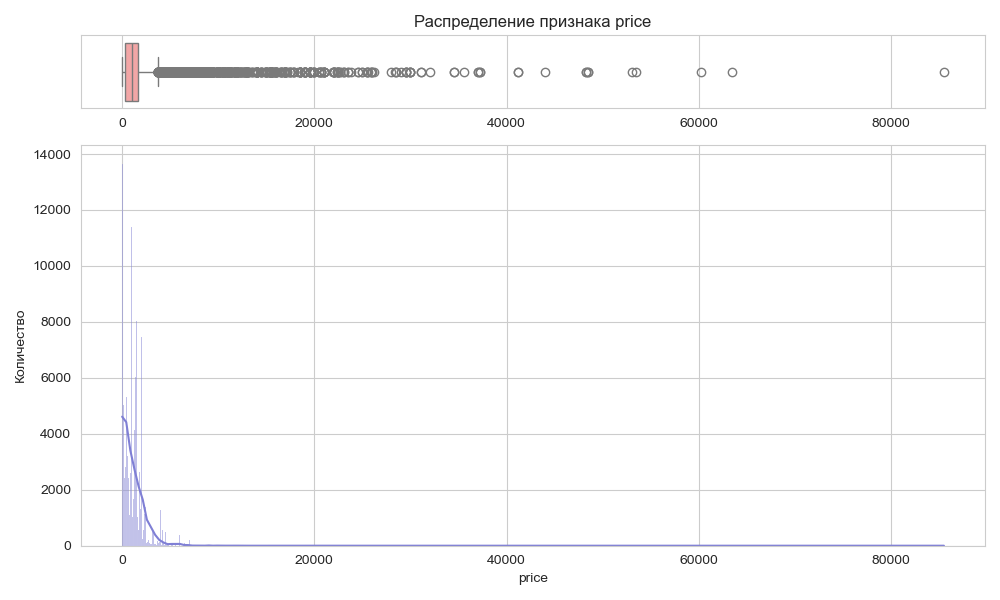
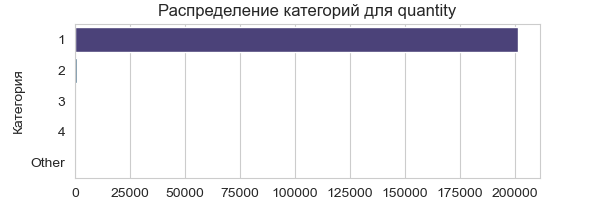
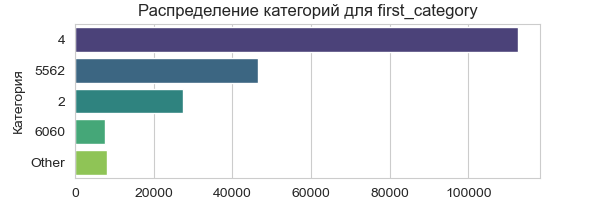
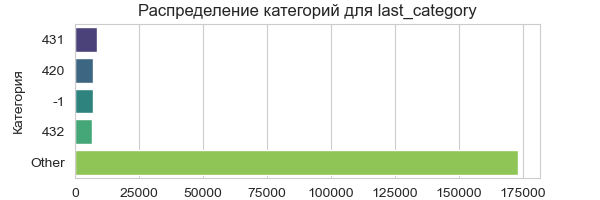
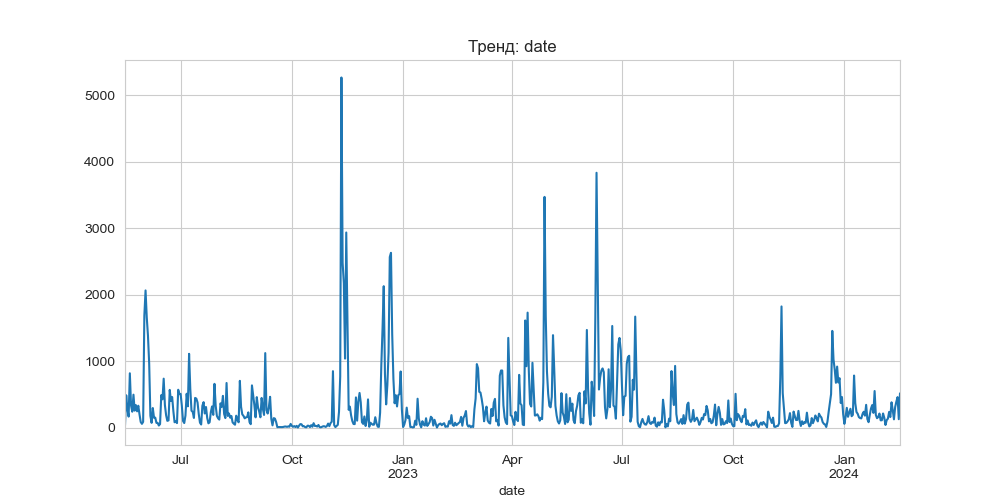

In [36]:
u.run_eda(purchases, numeric_columns=['price'], 
          categorical_columns=['quantity', 'first_category', 'last_category'], 
          time_columns=['date'], id_columns=['client_id'])

**Признак `price`**

В основном пользователи покупают товары стоимостью от 350 до 1700. График напоминает нормальное скошенное вправо распределение, однако заметно множество пиковых значений. Возможно это связано с повышенным спросом на определенные товары.

Ранее было замечено, что в признаке `price` присутствуют подозрительные значения. На графике можно заметить пик с минимальной ценой, а также видны выбросы в правой части графика.

Посмотрим, сколько покупок с ценой менее 5, а также стоимостью более 10000.

In [38]:
print('< 5 Количество ', (purchases['price'] < 5).sum(), ', доля', (purchases['price'] < 5).mean())

print('> 10000 Количество ', (purchases['price'] > 10_000).sum(), ', доля', (purchases['price'] > 10_000).mean())

< 5 Количество  2325 , доля 0.011498061402120589
> 10000 Количество  332 , доля 0.0016418737141952841


Доля таких значений составляет менее 2%, стоит их удалить.


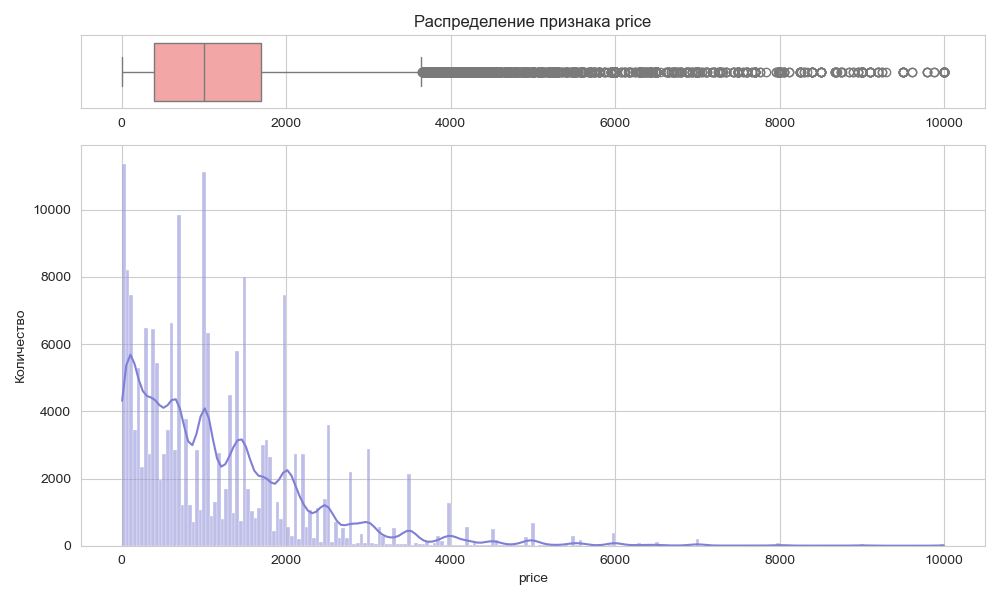
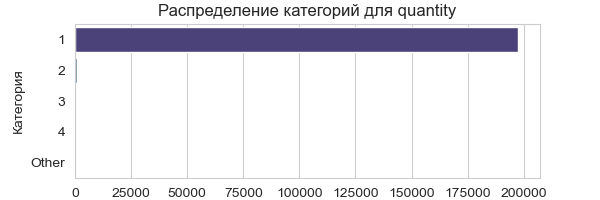
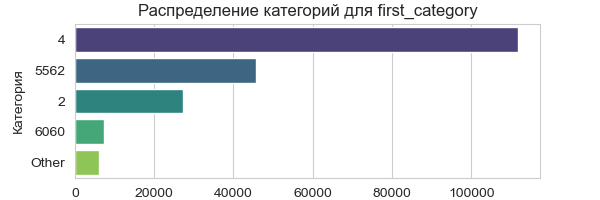
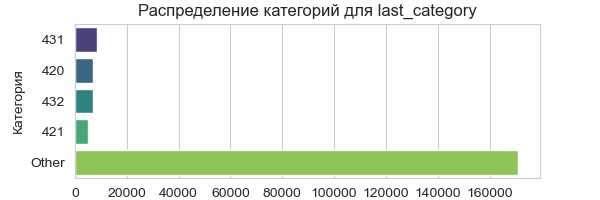
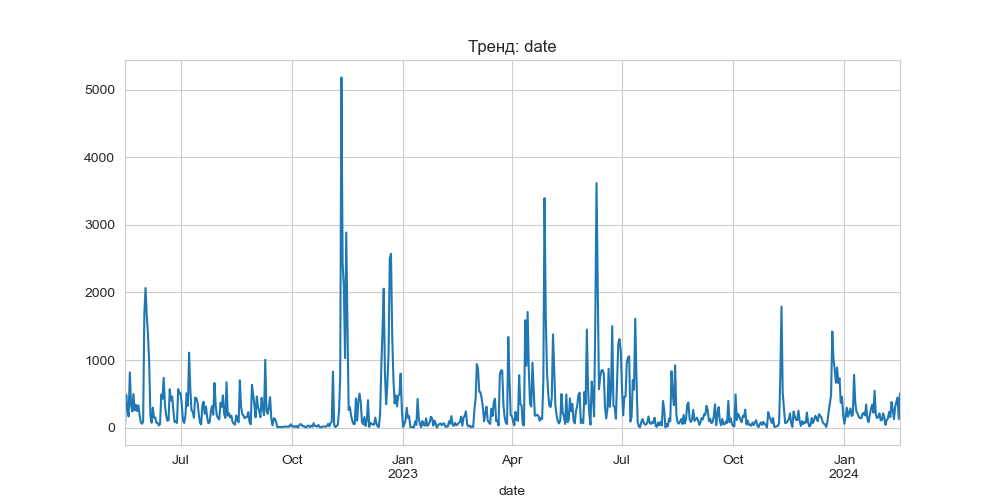

In [40]:
purchases = purchases[(purchases['price'] > 5) & (purchases['price'] < 10_000)]

u.run_eda(purchases, numeric_columns=['price'], 
          categorical_columns=['quantity', 'first_category', 'last_category'], 
          time_columns=['date'], id_columns=['client_id'])

**Категориальные признаки**

В большинстве случаев приобреталась 1 единица товара.

Самые популярные категории - 4 и 28. На верхнем уровне вложенности встречается гораздо меньше различных категорий. Также у многих товаров не указана категория.

**Признак `date`**

Более половины покупок зафиксированы в 2023 году. Видны всплески покупок в летний и предновогодний периоды.

<br>

**<font size=3>Таблица `messages`</font>**

В таблице 2 категориальных признака:

- `event` - действие с сообщением 
- `channel` - канал рассылки

2 временных признака:

- `date` - дата действия
- `created_at` - дата-время полностью


Изучим подробнее признаки данной таблицы.


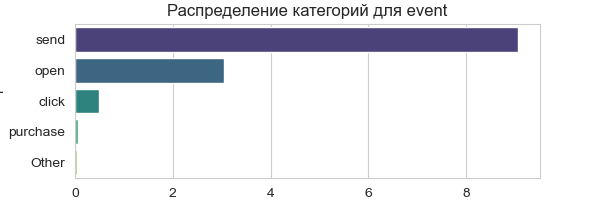
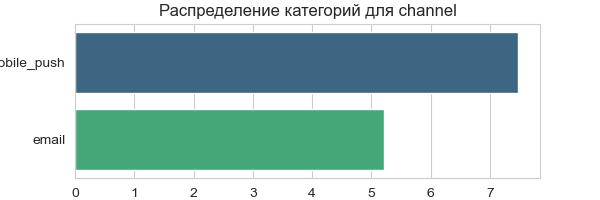
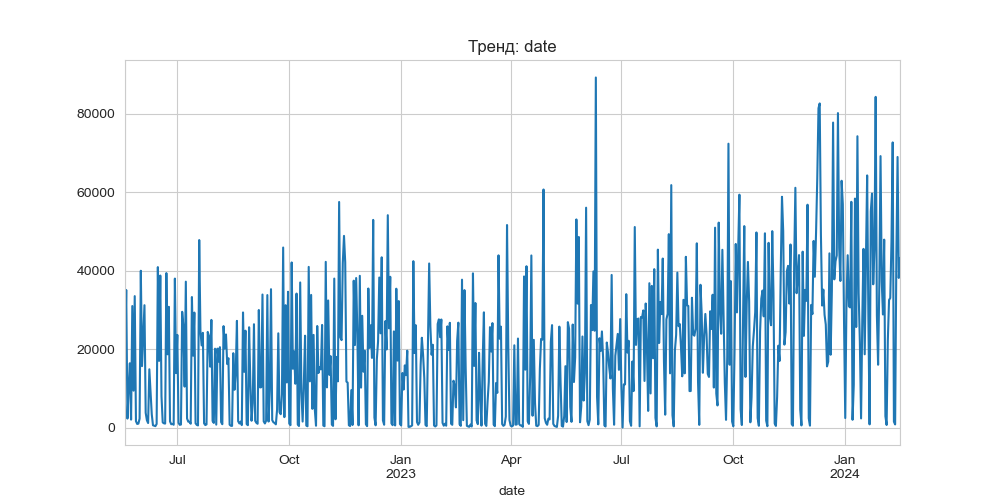
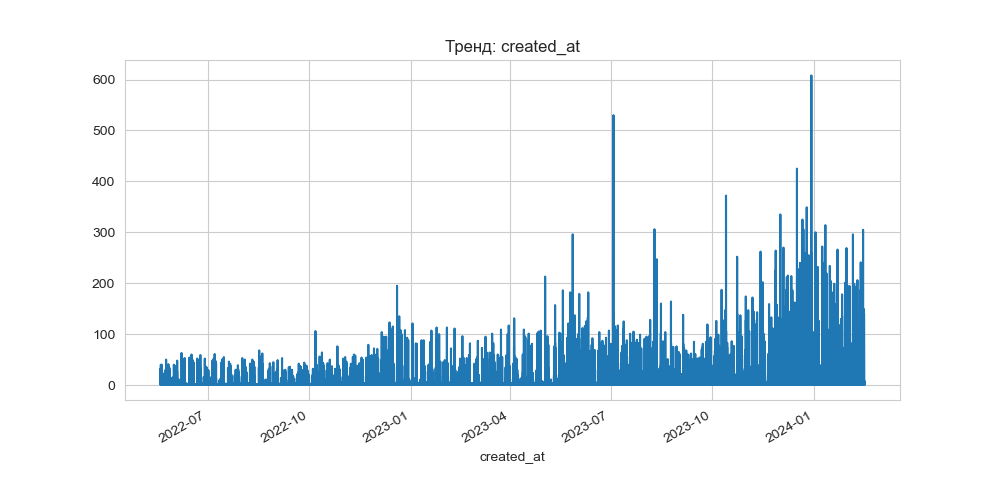

In [43]:
u.run_eda(messages, categorical_columns=['event', 'channel'],
        time_columns=['date', 'created_at'], id_columns=['bulk_campaign_id', 'client_id'])

Отправка рассылки - наиболее частое событие, также было открыто менее половины рассылок.

Мобильные рассылки случаются чаще рассылок по почте.

Рассылки зафиксированы в период с 19.05.2022 по 15.02.2024. За последний год значительно увеличилось количество рассылок, однако это не коррелирует с количеством покупок.

<br>

**<font size=3>Таблица `target`</font>**



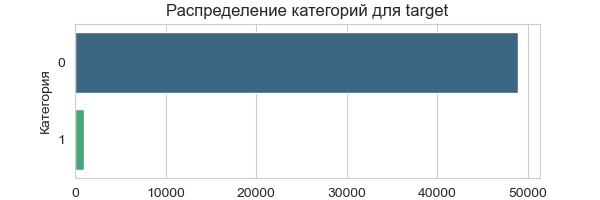

In [45]:
u.run_eda(target, categorical_columns=['target'], id_columns=['client_id'])

В целевом признаке присутствует сильный дисбаланс классов большинство пользователей не совершат покупку. Перед обучением модели стоит воспользоваться комбинированными методами балансировки классов, а также использовать взвешивание классов. 

### **Вывод**

На данном этапе:

- изучен харакрет распределения данных
- устранены аномальные значения признака `price`
- обнаружено отсутствие зависимости между увеличением количества рассылок и покупками
- выявлен дисбаланс классов
  

<a name='5'></a>

## **Генерация новых признаков**

**<font size=3>Таблица `purchases`</font>**

In [49]:
purchases.head()

,client_id,quantity,price,category_ids,date,message_id,first_category,last_category
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,431
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,432
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,413


В столбце `price` хранится стоимость за одну единицу товара. Добавим столбец с итоговой стоимостью.

In [51]:
purchases['total_cost'] = purchases['quantity'] * purchases['price']
purchases.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,client_id,quantity,price,category_ids,date,message_id,first_category,last_category,total_cost
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431,1999.0
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d,4,431,2499.0
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843,4,431,6499.0
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843,4,432,4999.0
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843,4,413,4999.0


Посчитаем суммарную стоимоть товаров у каждого пользователя за каждыйй день, и вычислим медианное значение у каждого пользователя.

In [53]:
df_p1 = purchases.pivot_table(index=['client_id', 'date'], values='total_cost', aggfunc='sum').reset_index()
df_p1 = df_p1.pivot_table(index='client_id', values='total_cost', aggfunc='median').reset_index()

print(df_p1.shape)
df_p1.head()

(49707, 2)


,client_id,total_cost
0,1515915625468060902,6993.0
1,1515915625468061003,16235.0
2,1515915625468061099,299.0
3,1515915625468061100,2098.0
4,1515915625468061170,5412.0


Сгруппируем исходные данные по `client_id` и вычислим следующие показатели:
- последняя дата покупки
- медианная стоимость товара
- медианные показатели количества товаров
- моду для первой и второй категории

In [55]:
df_p2 = purchases.pivot_table(
    index='client_id',
    aggfunc={
        'date': 'max',
        'price': 'median',
        'quantity': 'median',
        'first_category': lambda x: mode(x, keepdims=False).mode,
        'last_category': lambda x: mode(x, keepdims=False).mode
    }
).reset_index()

print(df_p2.shape)
df_p2.head()

(49707, 6)


,client_id,date,first_category,last_category,price,quantity
0,1515915625468060902,2022-05-27,4,420,999.0,1.0
1,1515915625468061003,2023-01-04,4,615,2100.0,1.0
2,1515915625468061099,2022-05-17,4,424,299.0,1.0
3,1515915625468061100,2024-02-10,4,5717,1049.0,1.0
4,1515915625468061170,2023-06-17,4,420,2195.0,1.0


Вычислим количество дней, прошедших с последней покупки.

In [57]:
last_date = df_p2['date'].max() + pd.Timedelta(days=2)
df_p2['last_purchase'] = (last_date - df_p2['date']).dt.days

df_p2.head()

,client_id,date,first_category,last_category,price,quantity,last_purchase
0,1515915625468060902,2022-05-27,4,420,999.0,1.0,632
1,1515915625468061003,2023-01-04,4,615,2100.0,1.0,410
2,1515915625468061099,2022-05-17,4,424,299.0,1.0,642
3,1515915625468061100,2024-02-10,4,5717,1049.0,1.0,8
4,1515915625468061170,2023-06-17,4,420,2195.0,1.0,246


**<font size=3>Таблица `messages`</font>**

In [59]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Посчитаем количество действий, совершенных каждым пользователем, а также долю событий `open` и `click`. Все негативные события сохраним в одной переменной.

In [61]:
def transform_df(df):
    
    df.columns = [x[1] for x in df.columns.tolist()]
    df = df.reset_index()

    df = df.fillna(0)

    return df

df_m1 = messages.pivot_table(index='client_id', columns=['event'], 
                          values='bulk_campaign_id', aggfunc=['count'])

df_m1 = transform_df(df_m1)

df_m1['open_part'] = df_m1.apply(lambda row: 0 if row['send'] == 0 else row['open'] / row['send'], axis=1)
df_m1['click_part'] = df_m1.apply(lambda row: 0 if row['open'] == 0 else row['click'] / row['open'], axis=1)

df_m1['negative_events'] = df_m1['close'] + df_m1['complain'] + df_m1['hard_bounce'] + df_m1['hbq_spam'] + df_m1['soft_bounce'] + df_m1['unsubscribe']

print(df_m1.shape)
df_m1.head()

(53329, 15)


,client_id,click,close,complain,hard_bounce,hbq_spam,open,purchase,send,soft_bounce,subscribe,unsubscribe,open_part,click_part,negative_events
0,1515915625468060902,10.0,0.0,0.0,0.0,0.0,35.0,5.0,126.0,0.0,0.0,1.0,0.277778,0.285714,1.0
1,1515915625468061003,5.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,0.032468,1.000000,0.0
2,1515915625468061099,8.0,0.0,0.0,2.0,0.0,51.0,0.0,215.0,0.0,0.0,0.0,0.237209,0.156863,2.0
3,1515915625468061100,1.0,0.0,0.0,1.0,0.0,157.0,1.0,267.0,1.0,0.0,0.0,0.588015,0.006369,2.0
4,1515915625468061170,16.0,0.0,0.0,0.0,0.0,31.0,3.0,243.0,0.0,0.0,0.0,0.127572,0.516129,0.0


Вычислим каличество рассылок по каждому каналу, а также их долю.

In [63]:
df_m2 = messages.pivot_table(index='client_id', columns=['channel'], 
                          values='bulk_campaign_id', aggfunc=['count'])

df_m2 = transform_df(df_m2)
df_m2['channel_part'] = df_m2['email'] / (df_m2['email']+df_m2['mobile_push'])

print(df_m2.shape)
df_m2.head()

(53329, 4)


,client_id,email,mobile_push,channel_part
0,1515915625468060902,177.0,0.0,1.00000
1,1515915625468061003,165.0,0.0,1.00000
2,1515915625468061099,182.0,94.0,0.65942
3,1515915625468061100,0.0,428.0,0.00000
4,1515915625468061170,202.0,91.0,0.68942


С помощью даты первой и последней рассылки вычислим время существования аккаунта в днях.

In [65]:
max_date = messages['date'].max() + pd.Timedelta(days=2)

df_m3 = messages.pivot_table(
    index='client_id',
    values='date',
    aggfunc=lambda x: (max_date - x.min()).days
).reset_index()

df_m3.rename(columns={'date': 'account_duration_days'}, inplace=True)

df_m3.head()

,client_id,account_duration_days
0,1515915625468060902,639
1,1515915625468061003,638
2,1515915625468061099,639
3,1515915625468061100,639
4,1515915625468061170,633


**<font size=3>Объединение таблиц</font>**

Проверим размерности созданных таблиц и `target`.

In [67]:
print(f'Уникальные пользователи таблицы purchases {df_p1.shape[0]}')
print(f'Уникальные пользователи таблицы messages {df_m1.shape[0]}')
print(f'Уникальные пользователи таблицы target {target.shape[0]}')

Уникальные пользователи таблицы purchases 49707
Уникальные пользователи таблицы messages 53329
Уникальные пользователи таблицы target 49849


В таблице `purchases` меньше всего уникальных пользователей, так как ранее были удалены аномальные значения в данной таблице. Проверим, все ли пользователи таблицы `purchases` есть в таблице `target`.

In [69]:
df_p1['client_id'].isin(target['client_id']).all()

True

Все уникальные пользователи таблицы `purchases` находятся в таблице `target`, значит можно объединять созданные таблицы по левой таблице `df_p1`.

In [71]:
dfs = [df_p1, df_p2.drop(labels='date', axis=1), 
       df_m1.drop(labels=['close', 'complain', 'hard_bounce', 'hbq_spam', 'soft_bounce', 'unsubscribe'], axis=1),
       df_m2, df_m3,
       target
      ]

data = reduce(lambda left, right: pd.merge(left, right, on='client_id', how='left'), dfs)

print(data.shape)
data.head()

(49707, 20)


,client_id,total_cost,first_category,last_category,price,quantity,last_purchase,click,open,purchase,send,subscribe,open_part,click_part,negative_events,email,mobile_push,channel_part,account_duration_days,target
0,1515915625468060902,6993.0,4,420,999.0,1.0,632,10.0,35.0,5.0,126.0,0.0,0.277778,0.285714,1.0,177.0,0.0,1.00000,639.0,0
1,1515915625468061003,16235.0,4,615,2100.0,1.0,410,5.0,5.0,1.0,154.0,0.0,0.032468,1.000000,0.0,165.0,0.0,1.00000,638.0,1
2,1515915625468061099,299.0,4,424,299.0,1.0,642,8.0,51.0,0.0,215.0,0.0,0.237209,0.156863,2.0,182.0,94.0,0.65942,639.0,0
3,1515915625468061100,2098.0,4,5717,1049.0,1.0,8,1.0,157.0,1.0,267.0,0.0,0.588015,0.006369,2.0,0.0,428.0,0.00000,639.0,0
4,1515915625468061170,5412.0,4,420,2195.0,1.0,246,16.0,31.0,3.0,243.0,0.0,0.127572,0.516129,0.0,202.0,91.0,0.68942,633.0,0


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49707 entries, 0 to 49706
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              49707 non-null  int64  
 1   total_cost             49707 non-null  float64
 2   first_category         49707 non-null  int64  
 3   last_category          49707 non-null  int64  
 4   price                  49707 non-null  float64
 5   quantity               49707 non-null  float64
 6   last_purchase          49707 non-null  int64  
 7   click                  41860 non-null  float64
 8   open                   41860 non-null  float64
 9   purchase               41860 non-null  float64
 10  send                   41860 non-null  float64
 11  subscribe              41860 non-null  float64
 12  open_part              41860 non-null  float64
 13  click_part             41860 non-null  float64
 14  negative_events        41860 non-null  float64
 15  em

Данные успешно объединены, однако появились пропуски из-за отсутсвия информации о некоротых пользователях в таблице `messages`. Заполним пропуски значением -1.

In [74]:
data = data.fillna(-1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49707 entries, 0 to 49706
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              49707 non-null  int64  
 1   total_cost             49707 non-null  float64
 2   first_category         49707 non-null  int64  
 3   last_category          49707 non-null  int64  
 4   price                  49707 non-null  float64
 5   quantity               49707 non-null  float64
 6   last_purchase          49707 non-null  int64  
 7   click                  49707 non-null  float64
 8   open                   49707 non-null  float64
 9   purchase               49707 non-null  float64
 10  send                   49707 non-null  float64
 11  subscribe              49707 non-null  float64
 12  open_part              49707 non-null  float64
 13  click_part             49707 non-null  float64
 14  negative_events        49707 non-null  float64
 15  em

### **Вывод**

Из таблиц `purchases` и `messages` были созданы и объединены новые признаки, устранены пропуски.

<a name='4'></a>

## **Корреляционный анализ**

Построим матрицу корреляции для всех признаков таблицы `data`.

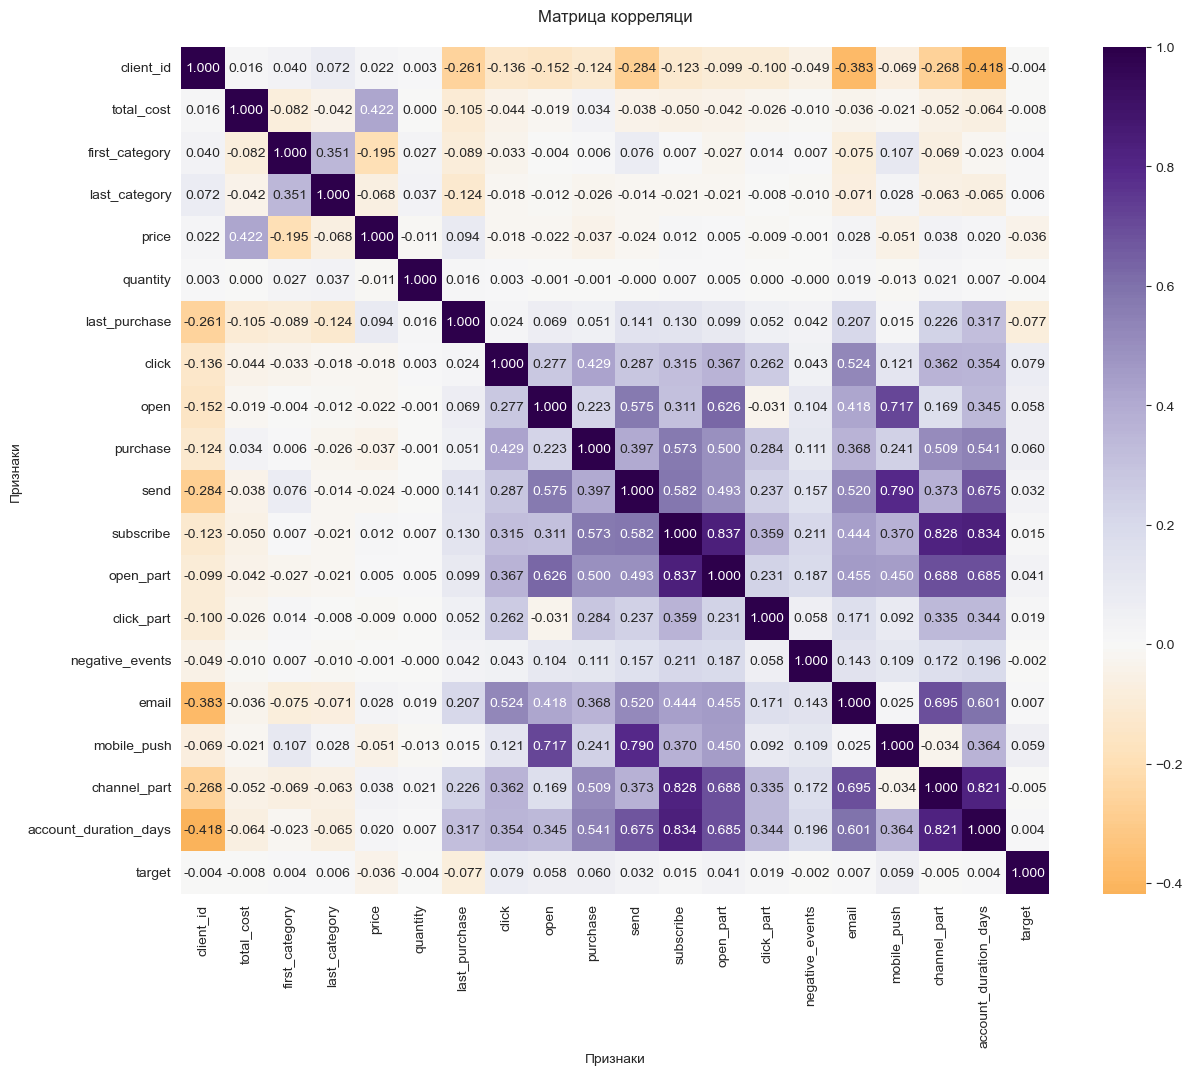

In [77]:
u.matrix(data.corr());

У целевого признака `target` наблюдается достаточно слабая корреляция с остальными признаками. Максимальная корреляция с количеством кликов (0.079), датой последней покупки (-0.077) и их количеством (0.06). А самая слабая корреляция с негативными событиями (-0.0015).

Также присутствуют признаки, между которыми достаточно высокая корреляция (~0.8), однако данные показатели не критичны и их можно оставить.

### **Вывод**

Была построена матрица корреляции, в результате чего наиболее коррелирующими с целевым признаком оказались: `click`, `last_purchase`, `purchase`. Мультиколлинеарности не обнаружено.

<a name='6'></a>

## **Модели МО**

### **Подготовка данных**

#### **Разделение данных**

Разделим данные на обучающую и тестовую выборки.

In [80]:
data = data.set_index('client_id')

X = data.drop(labels=['target'], axis=1)
y = data['target']

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print(X_train.shape, X_test.shape)

(39765, 18) (9942, 18)


Ранее был выявлен дисбаланс классов. Посмотрим, какая доля объектов минорного класса.

In [82]:
target = y_train.value_counts()

print(f'Доля объектов класса 1: {round(target[1] / (target[0] + target[1])*100, 2)}%')
target

Доля объектов класса 1: 1.93%


target
0    38997
1      768
Name: count, dtype: int64

Объектов минорного класса менее 2% для балансировки классов воспользуемся библиотекой `SMOTETomek`.

In [84]:
smt = SMOTETomek(sampling_strategy=0.5, random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)

target = y_train.value_counts()

print(f'Доля объектов класса 1: {round(target[1] / (target[0] + target[1])*100, 2)}%')
target

Доля объектов класса 1: 33.24%


target
0    38835
1    19336
Name: count, dtype: int64

Доля объектов минорного класса выросла до 33%.

#### **Категориальные и количественные признаки**

**Категориальные признаки**

В таблице 2 категориальных признака: `first_category`, `last_category`. Так как ранее был получен список возможных категорий и их количество, можно закодировать категории их частотой. Также можно попробовать использовать Oridinal-кодирование или не использовать кодировщик, так как категории являются целочисленными значениями.

Реализуем кодировщик по словарю.

In [86]:
cat_columns = ['first_category', 'last_category']

lst = []
purchases['category_ids'].apply(lambda x: u.reshape_list(x, lst))
freq_dict = pd.DataFrame(lst, columns=['category_ids']).value_counts().reset_index().set_index('category_ids')['count'].to_dict()


class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, freq_dict, default_value=0):
        self.freq_dict = freq_dict
        self.default_value = default_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # определение оригинального типа данных
        original_type = type(X)
        
        # преобразование в DataFrame, если это np.ndarray
        if isinstance(X, np.ndarray):
            if X.ndim == 1:  # одномерный массив
                X = pd.DataFrame(X, columns=["feature_0"])
            else:  # двумерный массив
                X = pd.DataFrame(X)

        # преобразование всех колонок
        transformed = X.applymap(lambda x: self.freq_dict.get(x, self.default_value))

        # преобразование в оригинальный формат
        if original_type is np.ndarray:
            return transformed.to_numpy()
        elif original_type is pd.DataFrame:
            return transformed
        elif original_type is pd.Series:
            return transformed.iloc[:, 0]
        else:
            return transformed.values.tolist()

encoder = FrequencyEncoder(freq_dict=freq_dict)

**Количественные признаки**

Признак `quantity` можно интерпретировать, и как категориальный, и как количественный, поэтому можно использовать разные методы кодирования.

Все остальные признаки являются количественными. Их сожно закодировать с помощью StandardScaler или MinMaxScaler.

In [88]:
rng_columns = ['quantity']

num_columns = X_train.columns.to_list()

num_columns.remove('quantity')
num_columns .remove('first_category')
num_columns.remove('last_category')
num_columns

['total_cost',
 'price',
 'last_purchase',
 'click',
 'open',
 'purchase',
 'send',
 'subscribe',
 'open_part',
 'click_part',
 'negative_events',
 'email',
 'mobile_push',
 'channel_part',
 'account_duration_days']

### **Пайплайны**

Реализуем пайплайны для предобработки признаков.

In [90]:

# заполнение пропусков и Ordinal-кодирование
cat_ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)),
     ('ord',  OrdinalEncoder( 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# заполнение пропусков и Ordinal-кодирование
rng_ord_pipe = Pipeline(
    [('simpleImputer_before_ord_rng', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)),
     ('ord_rng',  OrdinalEncoder(
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord_rng', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# заполнение пропусков и Frequency-кодирование
cat_pipe = Pipeline(
    [('simpleImputer_before_cat', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)),
     ('cat',  encoder),
     ('simpleImputer_after_cat', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0))
    ]
)

# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer([
     ('cat', cat_ord_pipe, cat_columns),
     ('num', MinMaxScaler(), num_columns),
     ('rng', rng_ord_pipe, rng_columns)
    ], 
)


### **Создание моделей**

Для обучения будут использованы следующие модели: LogisticRegression, DecisionTreeClassifier, XGBClassifier. Зададим гиперпараметры, перебор которых будет осуществляться с помощью OptunaSearchV. Также учтем дисбаланс классов с помощью соответствующих параметров моделей.

**LogisticRegression**

In [92]:
# подготовка данных и модель
pipe_final_LR = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE))
])

param_grid_LR = {
    
    # параметры моделей
    'models__C': optuna.distributions.FloatDistribution(0.01, 100),
    'models__penalty': optuna.distributions.CategoricalDistribution(['l1', 'l2']), 
    'models__solver': optuna.distributions.CategoricalDistribution(['liblinear', 'saga']), 
    
    'preprocessor__num': optuna.distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough']),
    'preprocessor__cat': optuna.distributions.CategoricalDistribution([cat_ord_pipe, cat_pipe, 'passthrough']),
    'preprocessor__rng': optuna.distributions.CategoricalDistribution([rng_ord_pipe, StandardScaler(), MinMaxScaler(), 'passthrough'])
    }

oscv_LR = OptunaSearchCV(
    pipe_final_LR, 
    param_grid_LR, 
    cv=10,
    scoring='roc_auc',
    n_trials=60,
    random_state=RANDOM_STATE
)

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains StandardScaler() which is of type StandardScaler.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains MinMaxScaler() which is of type MinMaxScaler.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains Pipeline(steps=[('simpleImputer_before_ord',
                 SimpleImputer(fill_value=-1, strategy='constant')),
                ('ord',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord',
                 SimpleImputer(strategy='most_frequent'))]) which is of type Pipeline.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains Pipeli

**DecisionTreeClassifier**

In [94]:

pipe_final_DTC = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE))
])

param_grid_DTC = {
    
    'models__max_depth': optuna.distributions.IntDistribution(2, 20),
    'models__max_features': optuna.distributions.IntDistribution(2, 30),
    
    'preprocessor__num': optuna.distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough']),
    'preprocessor__cat': optuna.distributions.CategoricalDistribution([cat_ord_pipe, cat_pipe, 'passthrough']),
    'preprocessor__rng': optuna.distributions.CategoricalDistribution([rng_ord_pipe, StandardScaler(), MinMaxScaler(), 'passthrough'])
    }

oscv_DTC = OptunaSearchCV(
    pipe_final_DTC, 
    param_grid_DTC, 
    cv=5,
    scoring='roc_auc',
    n_trials=60,
    random_state=RANDOM_STATE
)



Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains StandardScaler() which is of type StandardScaler.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains MinMaxScaler() which is of type MinMaxScaler.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains Pipeline(steps=[('simpleImputer_before_ord',
                 SimpleImputer(fill_value=-1, strategy='constant')),
                ('ord',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord',
                 SimpleImputer(strategy='most_frequent'))]) which is of type Pipeline.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains Pipeli

**XGBClassifier**

In [96]:
pipe_final_XGB = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, scale_pos_weight=target[0]/target[1]))
])

param_grid_XGB = {
    'models__n_estimators': optuna.distributions.IntDistribution(50, 300),
    'models__max_depth': optuna.distributions.IntDistribution(2, 10),
    'models__learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3),
    'models__subsample': optuna.distributions.FloatDistribution(0.6, 1.0),
    'models__alpha': optuna.distributions.FloatDistribution(0.1, 1.0),
    'models__lambda': optuna.distributions.FloatDistribution(1.0, 10.0),
    
    'preprocessor__num': optuna.distributions.CategoricalDistribution([StandardScaler(), MinMaxScaler(), 'passthrough']),
    'preprocessor__cat': optuna.distributions.CategoricalDistribution([cat_ord_pipe, cat_pipe, 'passthrough']),
    'preprocessor__rng': optuna.distributions.CategoricalDistribution([rng_ord_pipe, StandardScaler(), MinMaxScaler(), 'passthrough'])
}

# Используем OptunaSearchCV
oscv_XGB = OptunaSearchCV(
    pipe_final_XGB,
    param_grid_XGB,
    cv=5,
    scoring='roc_auc',
    n_trials=60,
    random_state=RANDOM_STATE
)

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains StandardScaler() which is of type StandardScaler.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains MinMaxScaler() which is of type MinMaxScaler.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains Pipeline(steps=[('simpleImputer_before_ord',
                 SimpleImputer(fill_value=-1, strategy='constant')),
                ('ord',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord',
                 SimpleImputer(strategy='most_frequent'))]) which is of type Pipeline.
Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains Pipeli

### **Обучение моделей**

Обучим модели и приверим качество метрики ROC-AUC на кросс-валидации по валидационной выборке.

In [98]:
oscv_LR.fit(X_train, y_train)

[I 2024-12-06 09:40:15,089] A new study created in memory with name: no-name-31e8790b-c368-4898-b4b7-108bfe41a442
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
[I 2024-12-06 09:40:26,826] Trial 0 finished with value: 0.6968998719025989 and parameters: {'models__C': 45.475558211614995, 'models__penalty': 'l1', 'models__solver': 'saga', 'preprocessor__num': StandardScaler(), 'preprocessor__cat': 'passthro

OptunaSearchCV(cv=10,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(transformers=[('cat',
                                                                           Pipeline(steps=[('simpleImputer_before_ord',
                                                                                            SimpleImputer(fill_value=-1,
                                                                                                          strategy='constant')),
                                                                                           ('ord',
                                                                                            OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                           unknown_value=nan)),
                                                                                           ('simpleImputer_after_ord',
                                                                                            SimpleImputer(strategy='most_frequent'))]),
                                                                           ['first...
                                    'preprocessor__rng': CategoricalDistribution(choices=(Pipeline(steps=[('simpleImputer_before_ord_rng',
                 SimpleImputer(fill_value=-1, strategy='constant')),
                ('ord_rng',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord_rng',
                 SimpleImputer(strategy='most_frequent'))]), StandardScaler(), MinMaxScaler(), 'passthrough'))},
               random_state=42, scoring='roc_auc')

In [99]:
oscv_LR.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleImputer_before_cat',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('cat',
                                                                   FrequencyEncoder(freq_dict={-1: 9700,
                                                                                               1: 3,
                                                                                               2: 27370,
                                                                                               3: 11,
                                                                                               4: 111769,
                                                                                               5: 2,
                                                                                               8: 1,
                                                                                               10: 2,
                                                                                               12: 7,
                                                                                               14: 4,
                                                                                               17: 3088,
                                                                                               18: 24282,
                                                                                               22: 2,
                                                                                               27: 12031,
                                                                                               28: 80029,
                                                                                               29: 4806,
                                                                                               30: 98,
                                                                                               31: 8485,
                                                                                               38: 2058,
                                                                                               44: 1680,
                                                                                               49: 2362,
                                                                                               50: 2,
                                                                                               57...
                                                  Pipeline(steps=[('simpleImputer_before_ord_rng',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('ord_rng',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord_rng',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['quantity'])])),
                ('models',
                 LogisticRegression(C=24.060569039235215,
                                    class_weight='balanced', penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [100]:
oscv_LR.best_score_

0.7907222513623869

In [101]:
oscv_DTC.fit(X_train, y_train)

[I 2024-12-06 09:51:33,669] A new study created in memory with name: no-name-8a2198d4-0240-4663-9e2b-c710d3c42f85
[I 2024-12-06 09:51:36,747] Trial 0 finished with value: 0.9542320097602742 and parameters: {'models__max_depth': 10, 'models__max_features': 26, 'preprocessor__num': 'passthrough', 'preprocessor__cat': Pipeline(steps=[('simpleImputer_before_ord',
                 SimpleImputer(fill_value=-1, strategy='constant')),
                ('ord',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord',
                 SimpleImputer(strategy='most_frequent'))]), 'preprocessor__rng': 'passthrough'}. Best is trial 0 with value: 0.9542320097602742.
[I 2024-12-06 09:51:38,432] Trial 1 finished with value: 0.9515097351171671 and parameters: {'models__max_depth': 11, 'models__max_features': 8, 'preprocessor__num': 'passthrough', 'preprocessor__cat': Pipeline(steps=[('simpleImputer_

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(transformers=[('cat',
                                                                           Pipeline(steps=[('simpleImputer_before_ord',
                                                                                            SimpleImputer(fill_value=-1,
                                                                                                          strategy='constant')),
                                                                                           ('ord',
                                                                                            OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                           unknown_value=nan)),
                                                                                           ('simpleImputer_after_ord',
                                                                                            SimpleImputer(strategy='most_frequent'))]),
                                                                           ['first_...
                                    'preprocessor__rng': CategoricalDistribution(choices=(Pipeline(steps=[('simpleImputer_before_ord_rng',
                 SimpleImputer(fill_value=-1, strategy='constant')),
                ('ord_rng',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord_rng',
                 SimpleImputer(strategy='most_frequent'))]), StandardScaler(), MinMaxScaler(), 'passthrough'))},
               random_state=42, scoring='roc_auc')

In [102]:
oscv_DTC.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', 'passthrough',
                                                  ['first_category',
                                                   'last_category']),
                                                 ('num', StandardScaler(),
                                                  ['total_cost', 'price',
                                                   'last_purchase', 'click',
                                                   'open', 'purchase', 'send',
                                                   'subscribe', 'open_part',
                                                   'click_part',
                                                   'negative_events', 'email',
                                                   'mobile_push',
                                                   'channel_part',
                                                   'account_duration_days']),
                                                 ('rng', StandardScaler(),
                                                  ['quantity'])])),
                ('models',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=12,
                                        max_features=15, random_state=42))])

In [103]:
oscv_DTC.best_score_

0.9621092661020352

In [104]:
oscv_XGB.fit(X_train, y_train)

[I 2024-12-06 09:54:42,841] A new study created in memory with name: no-name-9ebcfab1-357c-4285-a463-aeebbe62326d
[09:54:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[09:54:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[09:54:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[09:54:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[09:54:46] WARNING: C:\buildkite-agent\builds\buildkite-wi

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(transformers=[('cat',
                                                                           Pipeline(steps=[('simpleImputer_before_ord',
                                                                                            SimpleImputer(fill_value=-1,
                                                                                                          strategy='constant')),
                                                                                           ('ord',
                                                                                            OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                           unknown_value=nan)),
                                                                                           ('simpleImputer_after_ord',
                                                                                            SimpleImputer(strategy='most_frequent'))]),
                                                                           ['first_...
                                    'preprocessor__rng': CategoricalDistribution(choices=(Pipeline(steps=[('simpleImputer_before_ord_rng',
                 SimpleImputer(fill_value=-1, strategy='constant')),
                ('ord_rng',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord_rng',
                 SimpleImputer(strategy='most_frequent'))]), StandardScaler(), MinMaxScaler(), 'passthrough'))},
               random_state=42, scoring='roc_auc')

In [105]:
oscv_XGB.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['first_category',
                                                   'last_category']),
                                                 ('...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               lambda=5.54579734178756,
                               learning_rate=0.21921914344895221, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=241,
                               n_jobs=None, ...))])

In [106]:
oscv_XGB.best_score_

0.9952915069824867

### **Оценка качества моделей**

Максимальное качество метрики было получено с помощью модели градиентного бустинга (0.996), самое низкое качество показала модель логистической регрессии (0.791). 

Проверим значение метрик на тестовой выборке. Для анализа посчтаем Accuracy, Precision, Recall, F1, ROC-AUC, также построим матрицу ошибок, ROC-кривую и проверим зависимость F1 от порога классификации.


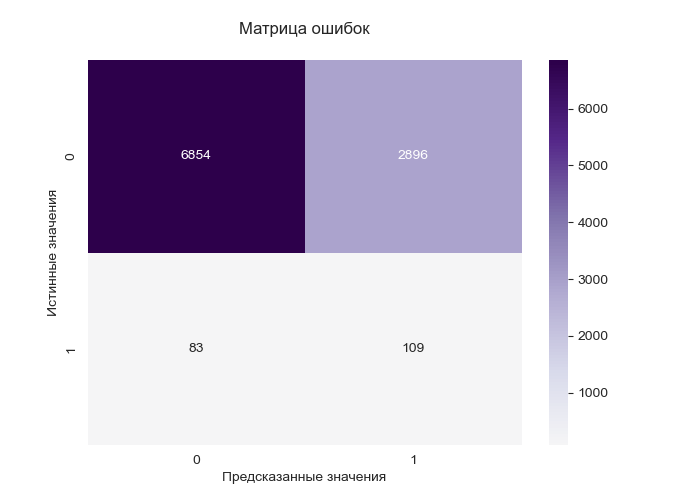
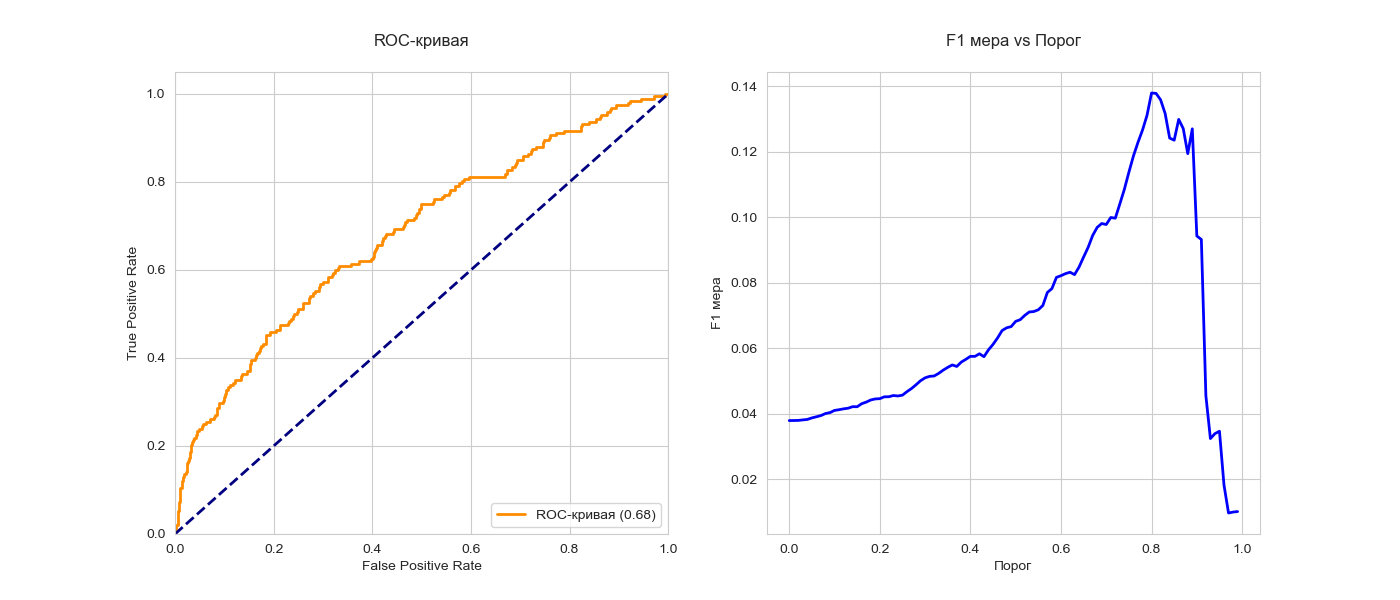
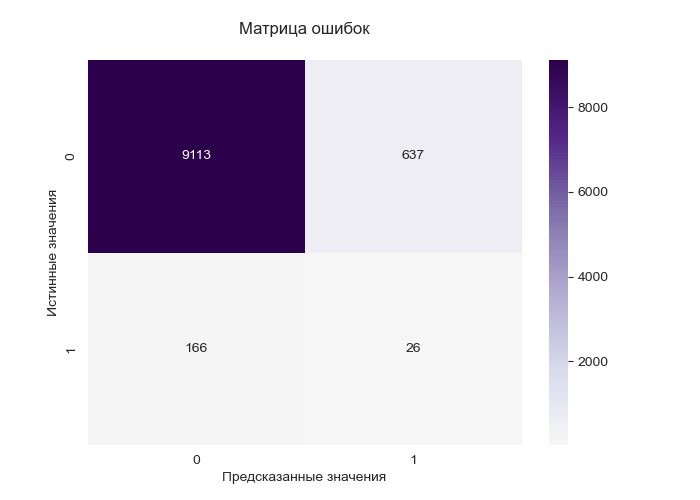
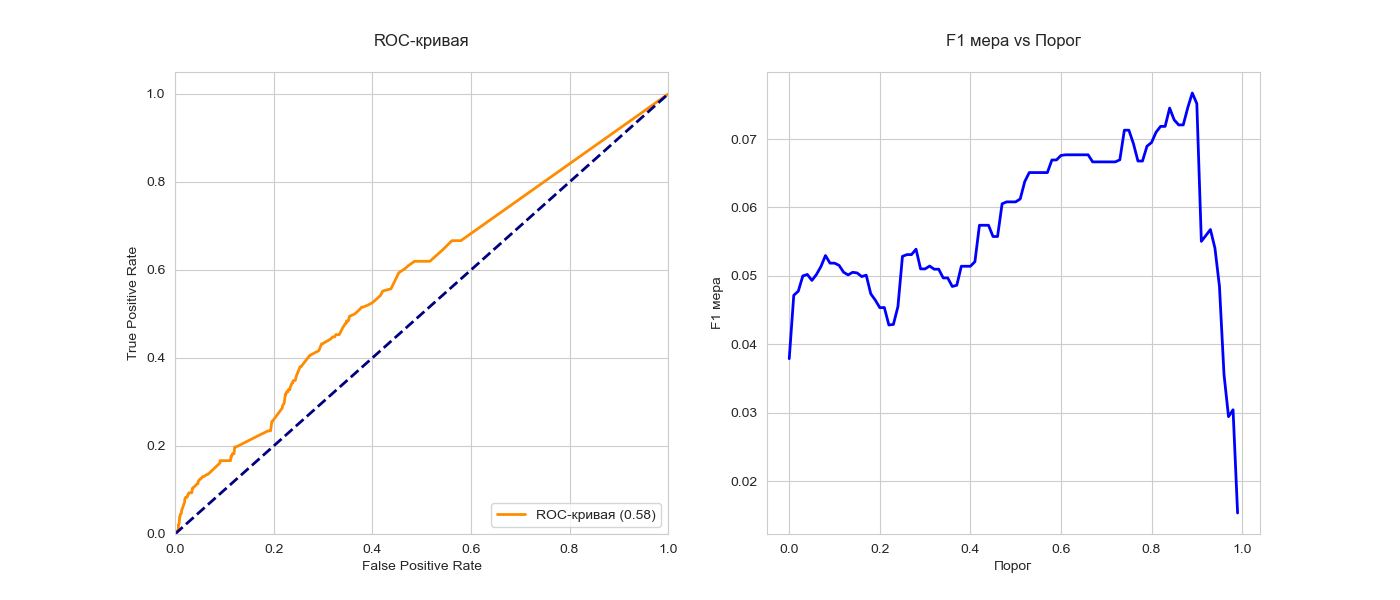
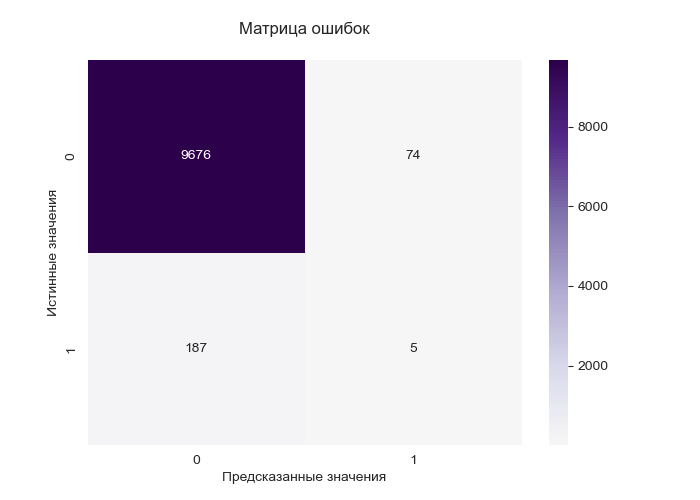
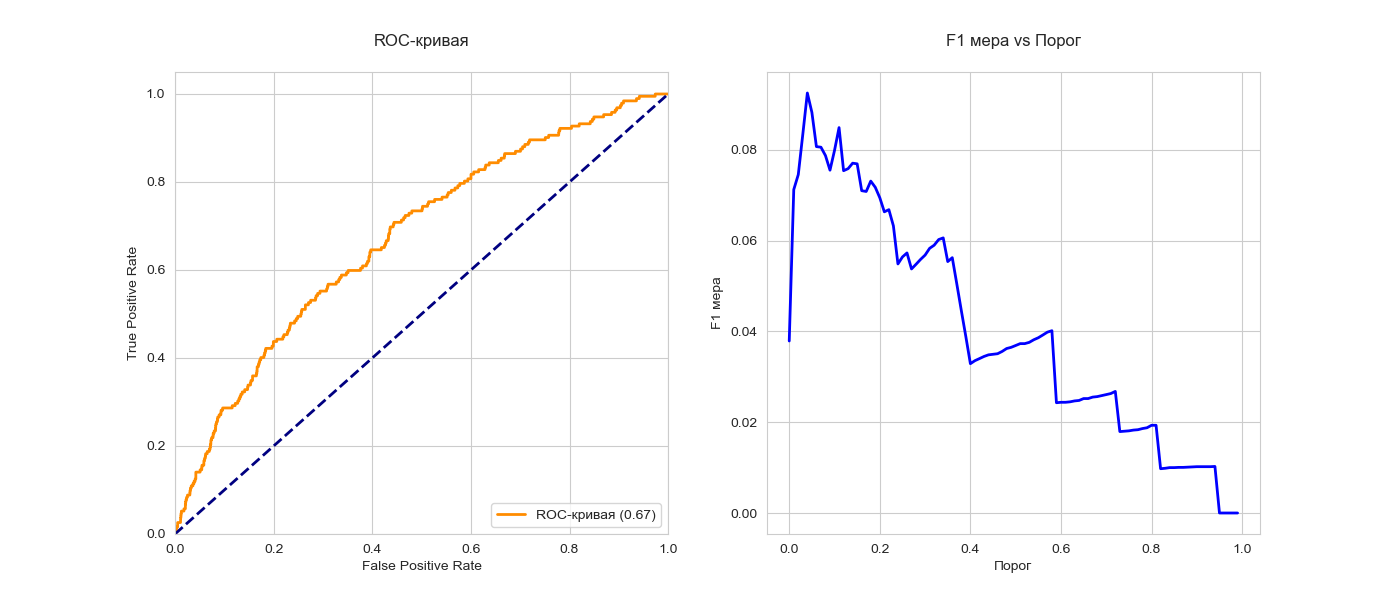

In [108]:
u.process_dfs(['LogisticRegression', 'DecisionTreeClassifier', 'XGBClassifier'], 
              [[y_test, oscv_LR.predict(X_test), oscv_LR.predict_proba(X_test)],
              [y_test, oscv_DTC.predict(X_test), oscv_DTC.predict_proba(X_test)],
              [y_test, oscv_XGB.predict(X_test), oscv_XGB.predict_proba(X_test)]],
              u.evaluate_model
             );

Показатели метрик значительно снизились, логистическая регрессия стала лучшей по метрикам ROC-AUC, F1 и Recall. Более сложные модели гораздо лучше адаптировались к тестовым данным, а из-за дисбаланса классов у них появились трудности с определением объектов минорного класса, за счет чего показатели метрик значительно снизились.

Улучшим модели с помощью настройки порога классификации. При устранении ошибки второго рода появится очень много ложноположительных предсказаний, поэтому настроим порог так, чтобы модель лучше определяла объекты обоих классов, максимизируя метрику F1. 

In [110]:
def best_threshold(y_true, y_proba):
    
    thresholds = np.linspace(0, 1, 1000)
    best_threshold = 0
    best_f1 = 0

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold


    return best_threshold, best_f1

In [111]:

ot_LR, optimal_f1 = best_threshold(y_test, oscv_LR.predict_proba(X_test)[:, 1])
print(f"Оптимальный порог: {ot_LR}, F1: {optimal_f1}")

ot_DTC, optimal_f1 = best_threshold(y_test, oscv_DTC.predict_proba(X_test)[:, 1])
print(f"Оптимальный порог: {ot_DTC}, F1: {optimal_f1}")

ot_XGB, optimal_f1 = best_threshold(y_test, oscv_XGB.predict_proba(X_test)[:, 1])
print(f"Оптимальный порог: {ot_XGB}, F1: {optimal_f1}")

y_LR = (oscv_LR.predict_proba(X_test)[:, 1] >= ot_LR).astype(int)
y_DTC = (oscv_DTC.predict_proba(X_test)[:, 1] >= ot_DTC).astype(int)
y_XGB = (oscv_XGB.predict_proba(X_test)[:, 1] >= ot_XGB).astype(int)



Оптимальный порог: 0.8058058058058059, F1: 0.14017094017094017
Оптимальный порог: 0.8898898898898899, F1: 0.07673860911270983
Оптимальный порог: 0.04204204204204204, F1: 0.09323583180987204



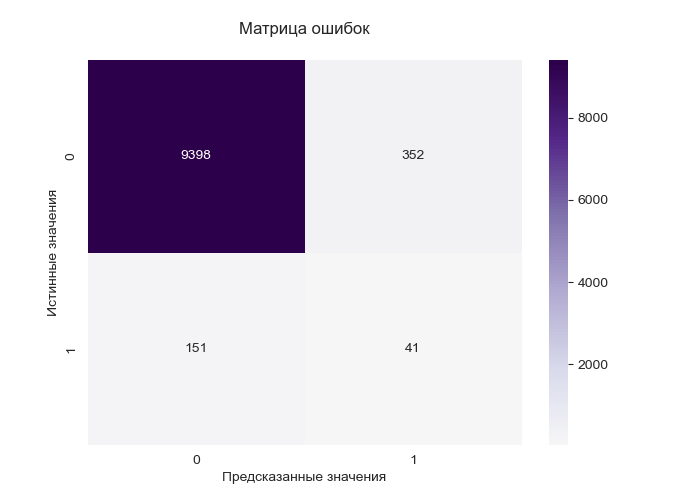
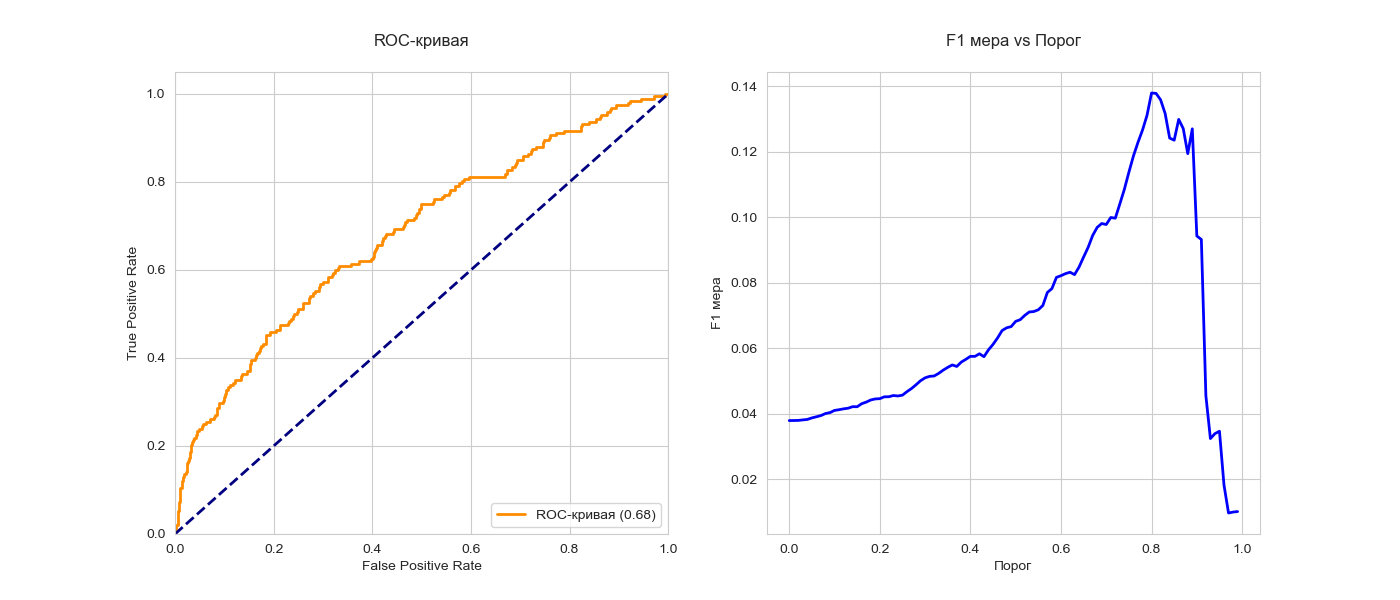
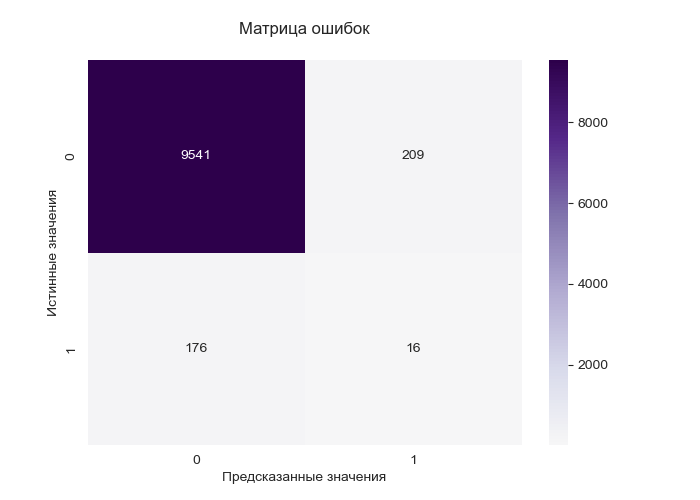
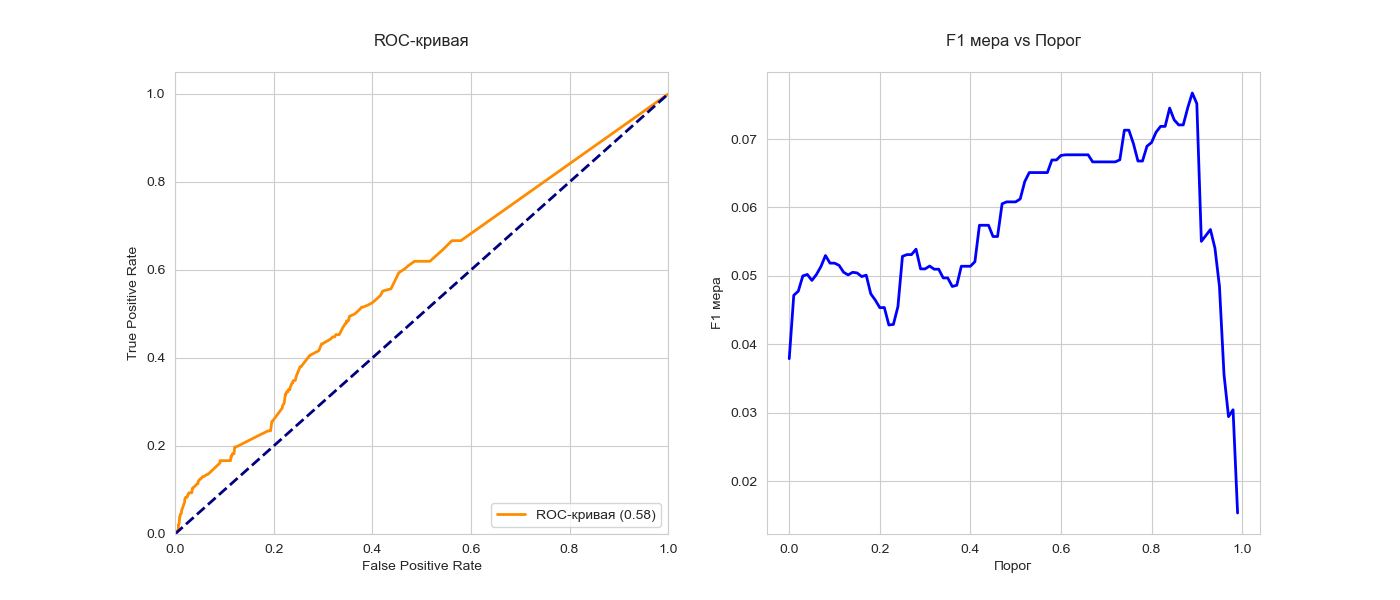
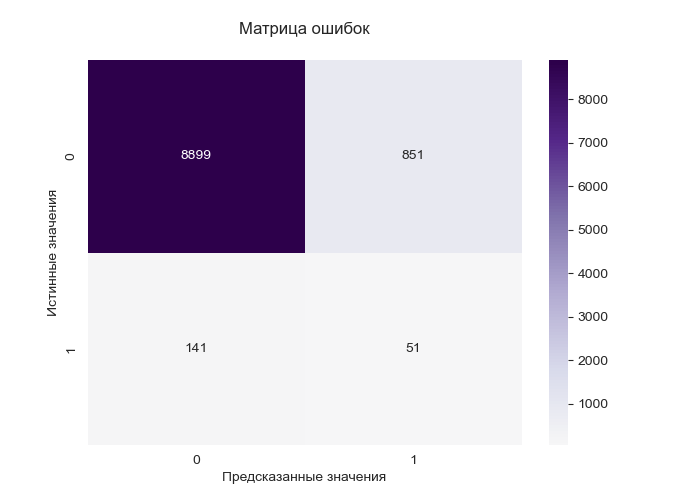
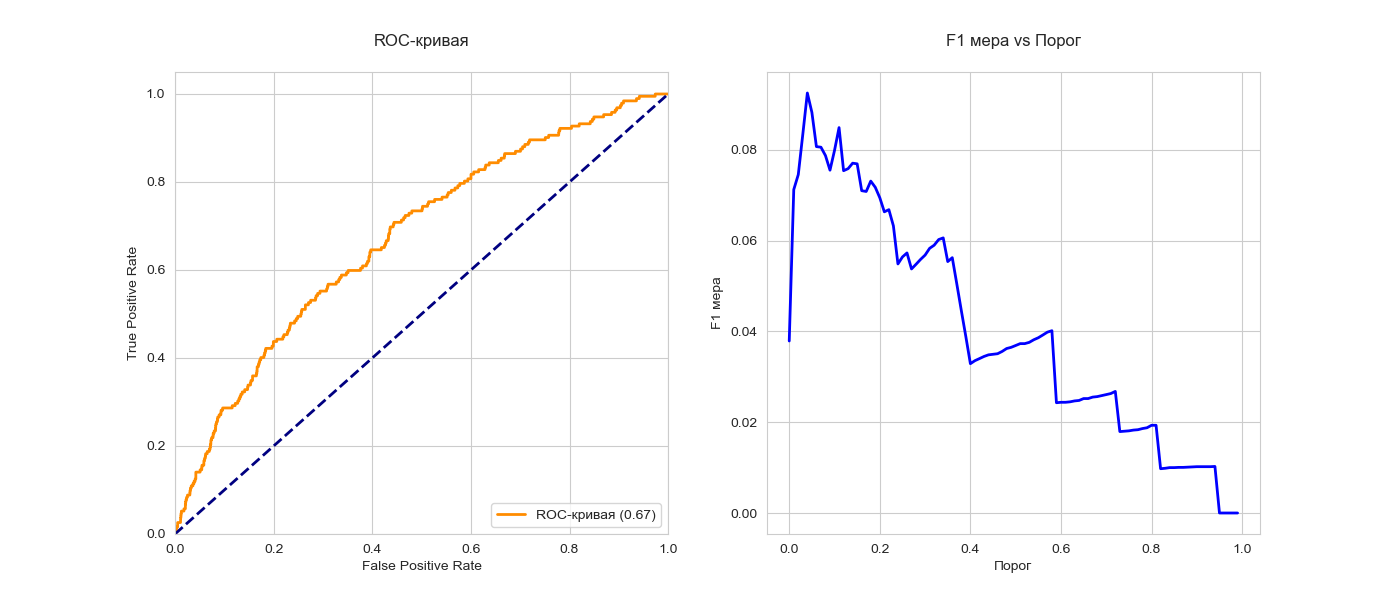

In [112]:
u.process_dfs(['LogisticRegression', 'DecisionTreeClassifier', 'XGBClassifier'], 
              [[y_test, y_LR, oscv_LR.predict_proba(X_test)],
              [y_test, y_DTC, oscv_DTC.predict_proba(X_test)],
              [y_test, y_XGB, oscv_XGB.predict_proba(X_test)]],
              u.evaluate_model
             );

Метрики моделей стали ближе друг к другу, однако из-за переобучения сложные модели могут вести себя более непредсказуемо, поэтому будет выбрана модель логистической регрессии.

### **Анализ важности признаков**

Посмотрим, какие признаки повлияли на предсказание модели.

In [114]:
# предобработка данных
def tr_test(oscv, X_test: pd.DataFrame) -> pd.DataFrame:

    preprocessor = oscv.best_estimator_['preprocessor']
    X_test_t = preprocessor.transform(X_test)

    column_names = X_test.columns

    return pd.DataFrame(X_test_t, columns=column_names)
    
X_test_t = tr_test(oscv_LR, X_test)
X_test_t.head()

,total_cost,first_category,last_category,price,quantity,last_purchase,click,open,purchase,send,subscribe,open_part,click_part,negative_events,email,mobile_push,channel_part,account_duration_days
0,27370.0,379.0,0.021052,0.299510,0.185647,0.015748,0.000788,0.024390,0.019449,0.25,0.100000,0.013699,0.014815,0.001148,0.023965,0.500000,0.429688,0.0
1,1228.0,55.0,0.031607,0.449615,0.647426,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,45640.0,41.0,0.009302,0.132393,0.074883,0.007874,0.003940,0.024390,0.013776,0.25,0.112121,0.020548,0.014815,0.013777,0.013508,0.634146,0.090625,0.0
3,111769.0,4698.0,0.097910,0.119784,0.458658,0.081365,0.042553,0.085366,0.066045,0.25,0.132716,0.021453,0.007407,0.289323,0.000436,1.000000,1.000000,0.0
4,9700.0,9700.0,0.012004,0.034774,0.010920,0.005249,0.000788,0.024390,0.020259,0.25,0.100000,0.013699,0.007407,0.001148,0.022658,0.500000,0.157812,0.0


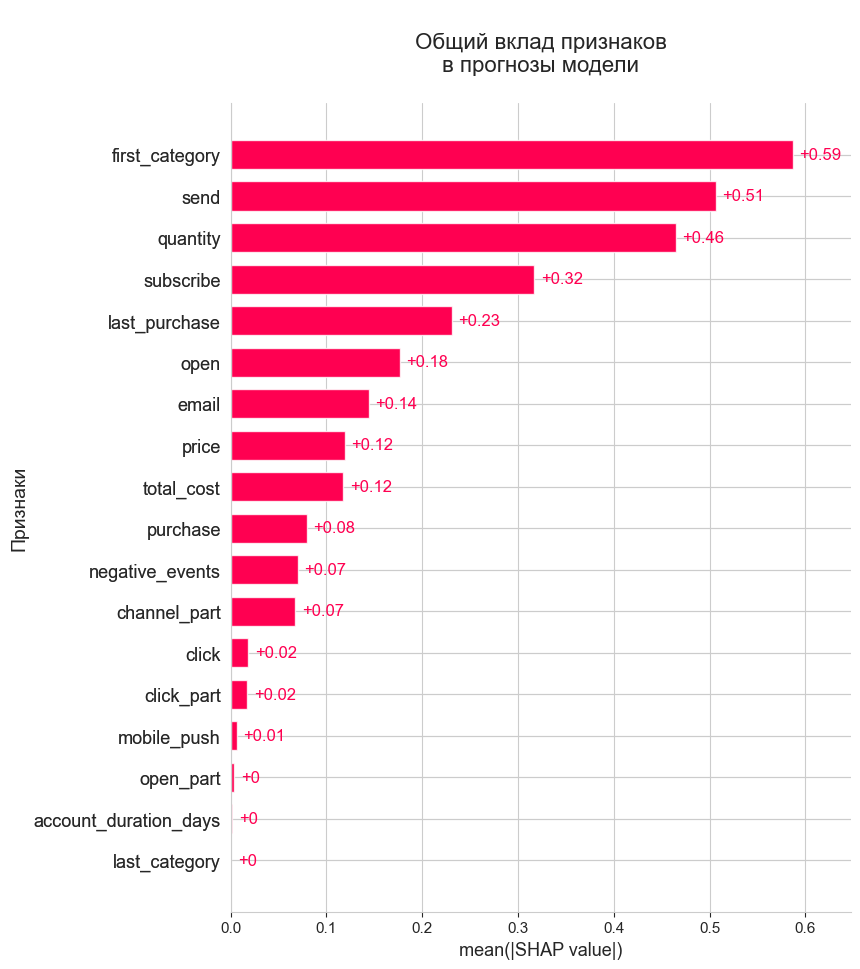

In [115]:
def shap_plots_fig(shap_values, columns, type_p='bw'):
    
    fig, ax = plt.gcf(), plt.gca()

    if type_p == 'br':
        shap.plots.bar(shap_values, show=False,
                       max_display=len(columns))
        title = '\nОбщий вклад признаков\nв прогнозы модели\n'
        
    elif type_p == 'bw':
        shap.plots.beeswarm(shap_values, show=False,
                            max_display=len(columns))
        title = '\nВклад признаков\nв каждое предсказание модели\n'
    
    ax.set_title(title, fontsize=16)
    ax.set_ylabel('Признаки', fontsize=14)

    plt.show()
    
def shap_plots_bar(oscv, X_test_t: pd.DataFrame):
    best_estimator = oscv.best_estimator_

    explainer = shap.Explainer(best_estimator['models'], X_test_t)
    shap_values = explainer(X_test_t)
    shap_values = shap_values

    shap_plots_fig(shap_values, X_test_t.columns, type_p='br')
    
    return shap_values

shap_values = shap_plots_bar(oscv_LR, X_test_t)

Наиболее значимыми для модели признаками являются: основная категория, количество отправленных рассылок и количество товаров.

Посмотрим, какие значения признаков, в какую сторону склоняют предсказания модели.

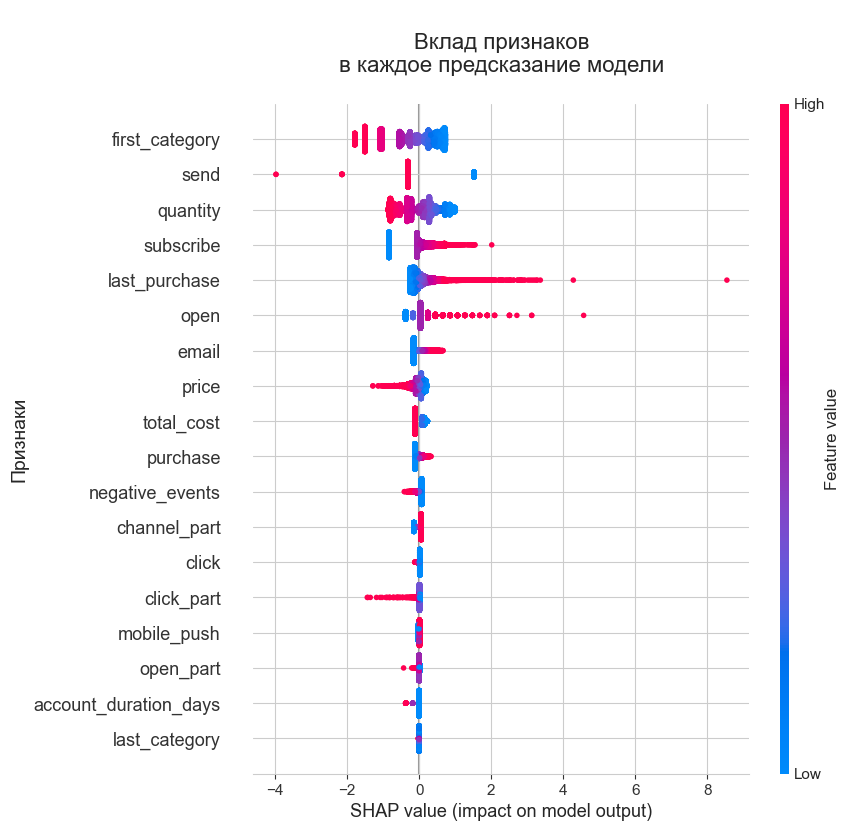

In [117]:
shap_plots_fig(shap_values, X_test.columns)

Вероятнее всего пользователь совершит повторную покупку, если:

- он покупал непопулярные категории товаров
- невысокое количество отправленных рассылок
- пользователь подписан
- много времени прошло с последней покупки
- пользователь открывает рассылку

Также можно заметить, что чем больше переходов по ссылке, тем меньше вероятность покупки. Это может говорить о том, что пользователи получают неактуальные предложения.

### **Вывод**

На данном этапе была проведена подготовка данных, в результате которой данные были разделены на обучающую и тестовую выборки, выделены количественные и категориальные признаки.

Были созданы пайплайны для кодировани признаков и обучения моделей. 

Был проведен поиск гиперпараметров моделей и их оценка, в результате чего была отобрана лучшая модель логистической регрессии и настроен порог (0.81) со следующими метриками:

- Accuracy - 0.95,
- Precision - 0.10,
- Recall - 0.21,
- F1 - 0.14,
- ROC-AUC - 0.68

Анализ важности признаков показал, что наибелее значимыми для модели признаками являются: основная категория, количество отправленных рассылок и количество товаров.


<a name='8'></a>

## **Итоговый вывод**

**Задача**

Для оптимизации процессов необходимо было создать модель, которая поможет выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Исходные данные**

Были загружены таблицы с информацией о покупках пользователй и историей рассылок. 

В результате предобработки данных были удалены полные дубликаты в таблице `messages`, извлечены данные с категориями товаров, получено более подробное представление о данных.

Исследовательский анализ данных показал наличие дисбаланса классов. Также были устранены аномальные значения в таблице `purchases`.

Также на основе таблиц `messages` и `purchases` были сгенерированы новые признаки, которые содержат информацию о действиях пользователей, их покупках и взаимодействии с сервисом.

Корреляционный анализ показал отсутствие сильной линейной связи с целевым признаком.

**Лучшая модель**

Для поиска лучшей модели были созданы пайплайны для кодирования признаков и обучения модели. Были рассмотрены следующие модели с разным набором гиперпараметров: **логистическая регрессия, дерево решений и метод градиентного бустинга**.

Несмотря на то что в данных присутствует слабая линейная зависимость, из-за дисбаланса классов модель логистической регрессии смогла найти более обобщенный подход к данным и не так сильно снизить качество метрики ROC-AUC (0.68) на тестовых данных.

**Структура модели:**

In [122]:
oscv_LR.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleImputer_before_cat',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('cat',
                                                                   FrequencyEncoder(freq_dict={-1: 9700,
                                                                                               1: 3,
                                                                                               2: 27370,
                                                                                               3: 11,
                                                                                               4: 111769,
                                                                                               5: 2,
                                                                                               8: 1,
                                                                                               10: 2,
                                                                                               12: 7,
                                                                                               14: 4,
                                                                                               17: 3088,
                                                                                               18: 24282,
                                                                                               22: 2,
                                                                                               27: 12031,
                                                                                               28: 80029,
                                                                                               29: 4806,
                                                                                               30: 98,
                                                                                               31: 8485,
                                                                                               38: 2058,
                                                                                               44: 1680,
                                                                                               49: 2362,
                                                                                               50: 2,
                                                                                               57...
                                                  Pipeline(steps=[('simpleImputer_before_ord_rng',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('ord_rng',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_after_ord_rng',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['quantity'])])),
                ('models',
                 LogisticRegression(C=24.060569039235215,
                                    class_weight='balanced', penalty='l1',
                                    random_state=42, solver='liblinear'))])

Влияние признаков на предсказание модели:

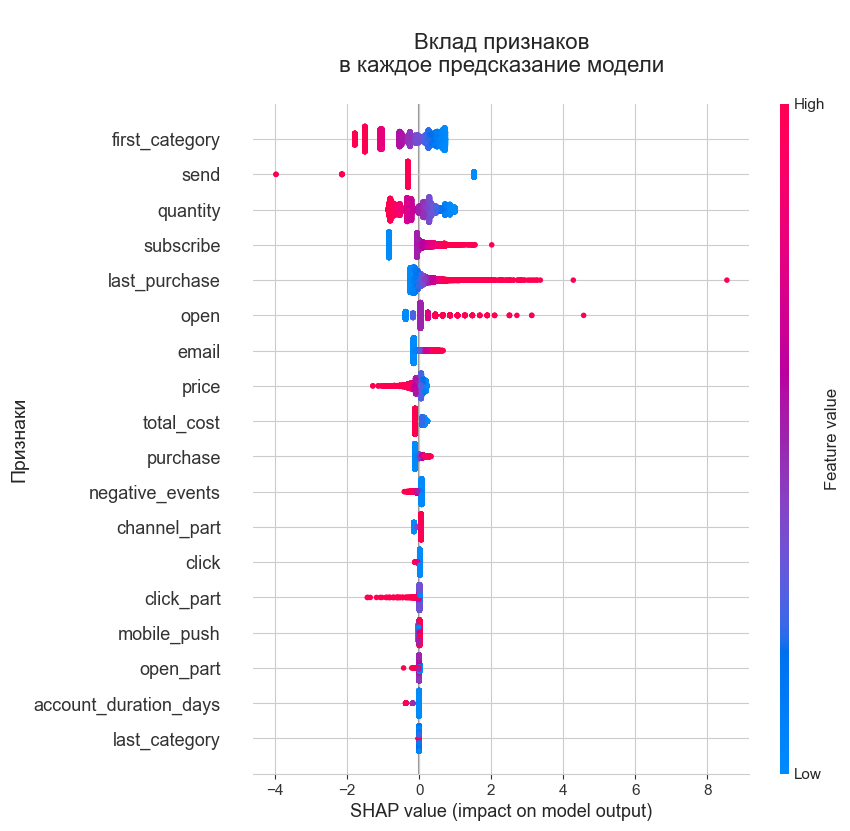

In [124]:
shap_plots_fig(shap_values, X_test.columns)

В результате анализа модели было выявлено, что совершивший покупку пользователь:
- ранее покупал непопулярные категории товаров
- получал невысокое количество отправленных рассылок
- подписан
- давно не совершал покупок
- открывает рассылку

  

**Итоги**

Рекомендуется 

- Создавать персонализированные рассылки во избежание ситуации, когда переход по ссылке негативно сказывается на совершении покупки.
- Анализировать поведение пользователей. Это позволит точнее предсказывать вероятность покупки и формировать более эффективные предложения.
- Использовать результаты модели для увеличения продаж. Фокус на таких пользователях может увеличить конверсию.
- Собирать обратную связь. Регулярные опросы пользователей помогут глубже понять их потребности и ожидания. 
- Работать над увеличением базы данных. Расширение базы пользователей за счет привлечения новых клиентов, а также дополнение текущей базы данными о поведении пользователей, поможет повысить точность предсказаний.
